# Aim of the notebook

We explore the specificity of each SRT method by definnig a negative marker purity score.

## Read packages

In [1]:
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from anndata import AnnData
import sklearn
from scipy.sparse import issparse
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from xb.calculating import coexpression_calculation,negative_marker_purity_coexpression

# Read all previously preprocessed files

In [5]:
path = '/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/figures/2.comparison_between_datasets/with_regional_anno_segmented/'
files=['anno_CosMx.h5ad', 'anno_Hybriss.h5ad', 'anno_MERFISH.h5ad','anno_ResolveBio.h5ad','anno_Vizgen.h5ad', 'anno_Xenium.h5ad']

In [8]:
adata_dict = {}
for file in files: 
    print(file)
    adata = sc.read(path+file)
    try:
        adata.X = adata.X.toarray()
    except: 
        print('nothing to format')
    adata.obs['x']=adata.obs['x_centroid']
    adata.obs['y']=adata.obs['y_centroid']
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    if file == 'anno_scRNAseq.h5ad':
        adata.var.index = adata.var.gene_symbol
    adata.var.index = adata.var.index.map(str.lower)
    adata_dict[file.split('.')[0]] = adata

anno_CosMx.h5ad
nothing to format
anno_Hybriss.h5ad
nothing to format
anno_MERFISH.h5ad
nothing to format
anno_ResolveBio.h5ad
nothing to format
anno_Vizgen.h5ad
nothing to format
anno_Xenium.h5ad
nothing to format


In [9]:
#reread single cell data since we need the updated version
adata_sc=sc.read('/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/data/scRNAseq/WMB-10Xv2-subset02_ready_for_xenium_benchmark.h5ad')

In [10]:
gjn=adata_sc.var.groupby(adata_sc.var.index).count().sort_values(by='name')
adata_sc=adata_sc[:,adata_sc.var.index.isin(gjn.index[gjn['name']==1])]

In [11]:
adata_dict['anno_scRNAseq']=adata_sc
adata_dict['anno_scRNAseq'].var.index=adata_dict['anno_scRNAseq'].var['gene_symbol'].map(str.lower)
adata_dict['anno_scRNAseq'].obs['spatial annotation']=adata_dict['anno_scRNAseq'].obs['anatomical_division_label_x']

In [12]:
dicti={'CosMx':'#FFA630', 'HybrISS':'#e82a92', 'ResolvedBiosciences':'#4DA1A9', 'Vizgen':'#2E5077', 'Xenium':'#56018f',
      'MERFISH_ABI':'#9EE493'}

In [13]:
color_dicitonary = {'anno_scRNAseq': 'black', 'anno_starmap': 'red', 'anno_allen_smfish': 'purple',
                    'anno_allen_merFISH': 'orangered',    'anno_Hybriss': 'limegreen',
 'anno_osmfish': 'yellow', 'anno_exseq': 'brown', 'anno_vizgen': '#E220F5', 'anno_baristaseq': 'orange',
'anno_r1_multisection_Xenium': 'steelblue','anno_ResolveBio':'forestgreen',  'anno_CosMx':'cyan'}

# We apply the NMP scores in the  cortex subset

In [14]:
cortical_clusters=['D: CTX','L1', 'L2/3', 'L4', 'L5' ,'L6a' ,'L6b','L1', 'L2/3', 'L4', 'L5' ,'L6a', 'L6b',
 'AUD1', 'AUD2' ,'AUD2/3', 'AUD4', 'AUD5', 'AUD6a', 'AUD6b',
 'MO1', 'MO2', 'MO2-3' ,'MO5','MO6a', 'MO6b','SSp1', 'SSp2', 'SSp2/3', 'SSp4', 'SSp5', 'SSp6a',
 'SSp6b','Isocortex','D: CTX','D: CTX [1]']

In [15]:
adata_sc = adata_sc[adata_sc.obs['anatomical_division_label_y'] == 'Isocortex']

In [16]:
files2=['anno_CosMx', 'anno_allen_smfish', 'anno_vizgen', 'anno_r1_multisection_Xenium', 'anno_starmap', 'anno_allen_merFISH', 'anno_baristaseq', 'anno_exseq', 'anno_Hybriss', 'anno_osmfish', 'anno_ResolveBio', 'anno_scRNAseq']

# First,calculate mean ratios, to then only use the ones above 1 for purity

In [17]:
df_con_cortex=pd.read_csv('../../figures/2.comparison_between_datasets/ratios_vs_sc/ratios_version_cortex_resegmented_segmentation.csv')

In [18]:
adata_sc=adata_dict['anno_scRNAseq']

In [19]:
adata_sc=adata_sc[adata_sc.obs['spatial annotation'].astype(str).isin(cortical_clusters)]

In [20]:
cortical_clusters=['D: CTX','L1', 'L2/3', 'L4', 'L5' ,'L6a' ,'L6b','L1', 'L2/3', 'L4', 'L5' ,'L6a', 'L6b',
 'AUD1', 'AUD2' ,'AUD2/3', 'AUD4', 'AUD5', 'AUD6a', 'AUD6b',
 'MO1', 'MO2', 'MO2-3' ,'MO5','MO6a', 'MO6b','SSp1', 'SSp2', 'SSp2/3', 'SSp4', 'SSp5', 'SSp6a',
 'SSp6b','Isocortex','D: CTX','Isocortex']

In [65]:
gns=adata_sc.var.groupby('gene_symbol').count().sort_values(by='name')
selgenes=gns[gns['name']==1].index
glow=[g.lower() for g in selgenes]
adata_sc=adata_sc[:,adata_sc.var.index.isin(glow)]
adata_dict['anno_Xenium'].obs.loc[:,'spatial annotation']=[d.replace('D:','').replace('[1]','').replace(' ','') for d in  adata_dict['anno_Xenium'].obs.loc[:,'region_annotation']]
adata_dict['anno_Hybriss'].obs['spatial annotation']=adata_dict['anno_Hybriss'].obs['region_annotation']

In [121]:
files=['anno_CosMx', 'anno_Hybriss', 'anno_MERFISH', 'anno_ResolveBio', 'anno_Vizgen', 'anno_Xenium']

anno_CosMx
(14002, 175)
(193380, 175)
Index(['acta2', 'adgrg1', 'adgrl2', 'adgrl3', 'adora1', 'adora2a', 'adra1d',
       'adrb2', 'agtr1a', 'agtr1b',
       ...
       'sstr2', 'sulf2', 'synpr', 'tacr1', 'tle4', 'trem2', 'vip', 'vipr1',
       'vipr2', 'vtn'],
      dtype='object', length=175)
(193380, 175)


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 422.97it/s]


anno_Hybriss
(10378, 39)
(193380, 39)
Index(['acta2', 'aldoc', 'calb2', 'calm2', 'cd24a', 'cnr1', 'crh', 'flt1',
       'foxj1', 'gad1', 'gad2', 'gfap', 'hexb', 'itpr2', 'lamp5', 'mbp',
       'mfge8', 'mrc1', 'npy', 'nrn1', 'pcp4', 'pdgfra', 'penk', 'plp1',
       'pthlh', 'pvalb', 'rorb', 'serpinf1', 'slc17a7', 'slc32a1', 'slc6a1',
       'sox10', 'sst', 'synpr', 'syt6', 'tac2', 'tbr1', 'vip', 'vtn'],
      dtype='object')
(193380, 39)


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 911.53it/s]


anno_MERFISH
(2038, 108)
(193380, 108)
Index(['acta2', 'adamts2', 'adra1b', 'alk', 'aqp4', 'bcl11b', 'bdnf', 'calb1',
       'calb2', 'camk2d',
       ...
       'th', 'thsd7a', 'tmem163', 'tox', 'trpc4', 'tshz2', 'unc13c', 'vip',
       'vipr2', 'vtn'],
      dtype='object', length=108)
(193380, 108)


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 1004.32it/s]


anno_ResolveBio
(10790, 73)
(193380, 73)
Index(['adamts2', 'aqp4', 'bcl11b', 'blnk', 'calb1', 'cartpt', 'ccn2', 'chat',
       'chodl', 'col24a1', 'csf1r', 'cspg4', 'cux2', 'cxcl14', 'deptor',
       'dkk3', 'egln3', 'egr2', 'fezf2', 'flt1', 'fos', 'foxp2', 'gad1',
       'gfap', 'htr3a', 'inpp4b', 'kit', 'lamp5', 'lhx6', 'lpl', 'man1a',
       'mog', 'nos1', 'nr4a2', 'ntsr1', 'nxph4', 'olig2', 'oprk1', 'otof',
       'pcp4', 'pde1a', 'pdgfra', 'pecam1', 'plp1', 'prox1', 'ptgs2', 'pthlh',
       'pvalb', 'rasgrf2', 'rbfox3', 'reln', 'rora', 'rorb', 'rspo1', 'satb2',
       'slc17a7', 'slc17a8', 'snap25', 'sncg', 'sox10', 'spi1', 'sst', 'syt6',
       'tacr1', 'tbr1', 'th', 'tle4', 'tox', 'trem2', 'trhr', 'tshz2', 'vip',
       'wnt7b'],
      dtype='object')
(193380, 73)


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 750.44it/s]


anno_Vizgen
(12928, 125)
(193380, 125)
Index(['adgrg1', 'adgrl2', 'adgrl3', 'adgrl4', 'adora1', 'adora2a', 'adra1b',
       'adra1d', 'adrb2', 'agtr1a',
       ...
       'slc17a8', 'slc32a1', 'sox9', 'sstr1', 'sstr2', 'tacr1', 'th', 'trhr',
       'vipr1', 'vipr2'],
      dtype='object', length=125)
(193380, 125)


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 548.37it/s]


anno_Xenium
(33264, 111)
(193380, 111)
Index(['acta2', 'adamts2', 'adgrl4', 'aqp4', 'bcl11b', 'bdnf', 'calb1',
       'calb2', 'cbln4', 'ccn2',
       ...
       'tacr1', 'th', 'thsd7a', 'tle4', 'tmem163', 'tox', 'trem2', 'trpc4',
       'unc13c', 'vip'],
      dtype='object', length=111)
(193380, 111)


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 240.85it/s]


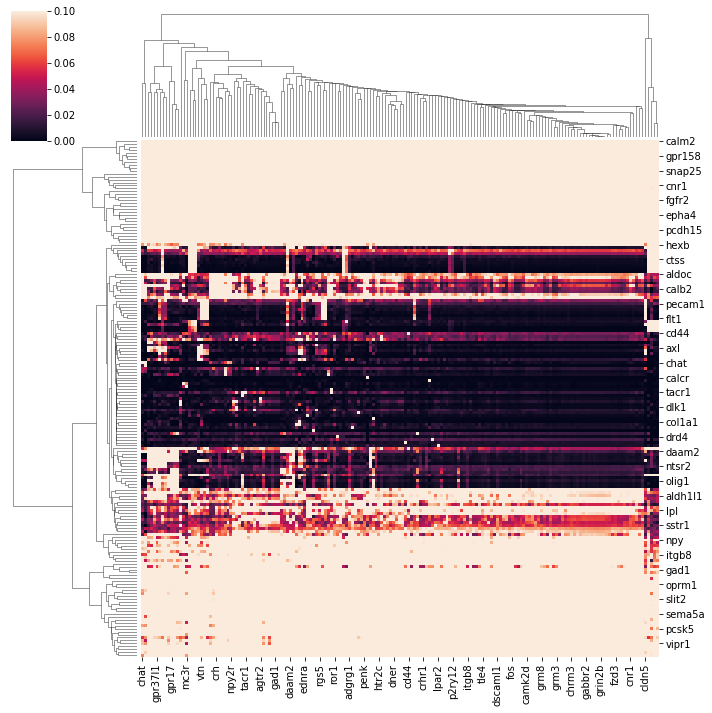

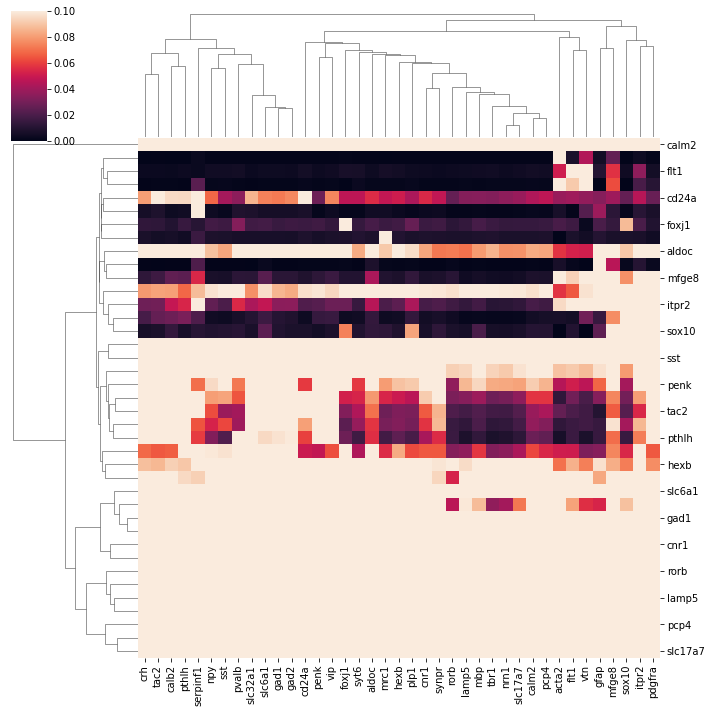

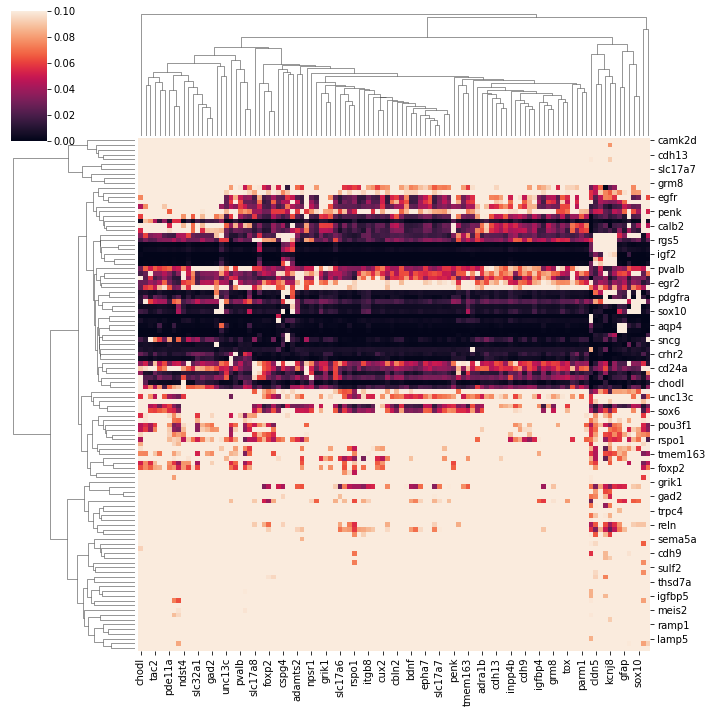

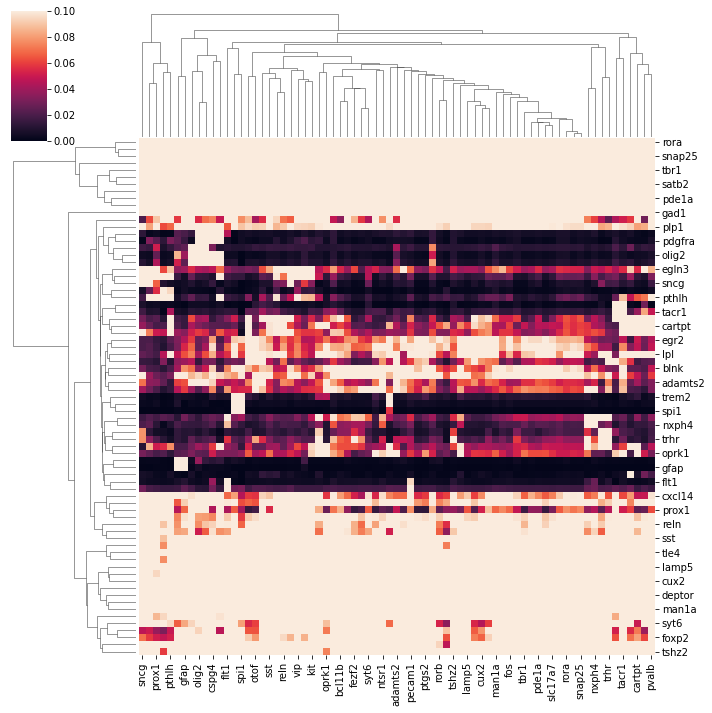

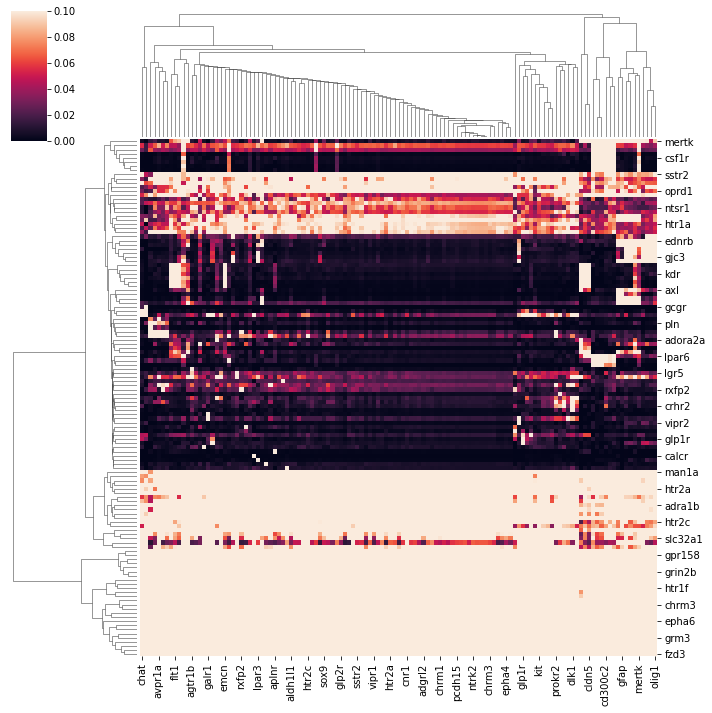

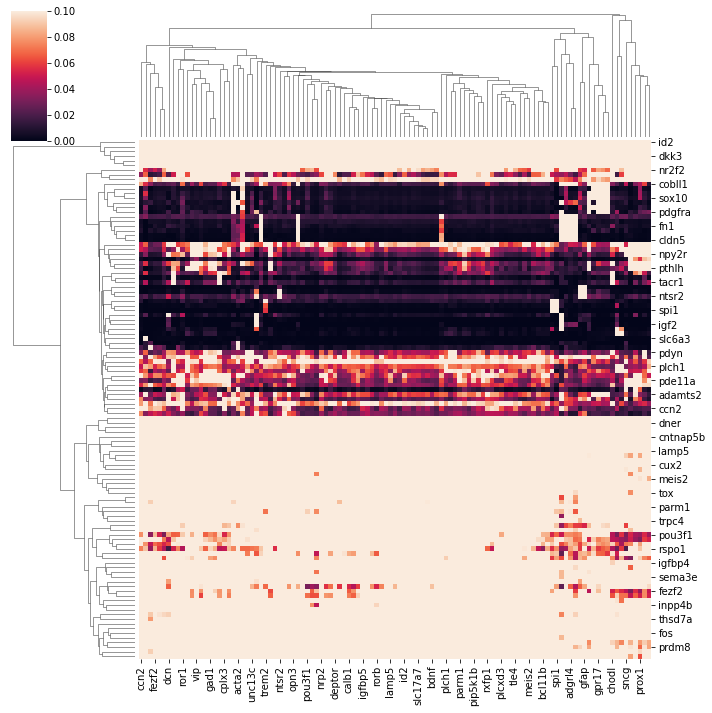

In [146]:
df_purity=pd.DataFrame()
df_ratio=pd.DataFrame()
purity_scores=[]
for fl in files:
    print(fl)
    adata_sp=adata_dict[fl]
    method=fl.split('anno_')[1]
    if method=='r1_multisection_Xenium':
        method='Xenium'
    dfilt=df_con_cortex[df_con_cortex['method']==method]
    dfilt=dfilt[dfilt['ratio']<10]
    adata_sp=adata_sp[:,adata_sp.var.index.isin(dfilt['gene'])]
    adata_sp=adata_sp[adata_sp.obs['spatial annotation'].astype(str).isin(cortical_clusters)]
    adata_sp.var_names=[x.lower() for x in adata_sp.var_names]
    adata_sc.var_names=[x.lower() for x in adata_sc.var_names]
    if np.sum(adata_sp.var_names.isin(adata_sc.var_names))>10:
        negative_marker_purity, purity_per_gene, purity_per_celltype,lowvals_sc,lowvals_sp,commongenes=negative_marker_purity_coexpression(adata_sp, adata_sc,pipeline_output=False)
        pur=pd.DataFrame(purity_per_celltype)
        for pr in pur.index:
            df_purity.loc[fl,pr]=pur.loc[pr,0]
    else:
        print(fl+' not possible')

In [147]:
purity_overall=pd.DataFrame(1-np.nanmean(df_purity,axis=1),index=df_purity.index)
df_purity_filt=1-df_purity#.loc[:,np.sum(df_purity>0,axis=0)>2]

In [148]:
gnall=[]
dsall=[]
vall=[]
for gn in  df_purity_filt.index:
    for ds in  df_purity_filt.columns:
        if df_purity_filt.loc[gn,ds]>0:
            vall.append(df_purity_filt.loc[gn,ds])
            gnall.append(gn)
            dsall.append(ds)

In [149]:
summary_of_results=pd.DataFrame([gnall,vall,dsall],index=['method','purity','gene']).transpose()

In [135]:
color_dicitonary = {
'anno_scRNAseq': 'black',
 'anno_starmap': 'red',
 'anno_allen_smfish': 'purple',
 'anno_MERFISH': '#9EE493',
    'anno_Hybriss': '#e82a92',
 'anno_osmfish': 'yellow',
 #'anno_seqFISH': 'cyan',
 'anno_exseq': 'brown',
 'anno_Vizgen': '#2E5077',
 'anno_baristaseq': 'orange',
 'anno_Xenium':'#56018f',
'anno_ResolveBio':'#4DA1A9', 
    'anno_CosMx':'#FFA630'}

In [136]:
sumu=summary_of_results.loc[:,['method','purity']].groupby('method').median()
order=sumu.sort_values(by='purity').index
summary_of_results['color']=summary_of_results['method'].map(color_dicitonary)
coli=[color_dicitonary[el] for el in order]

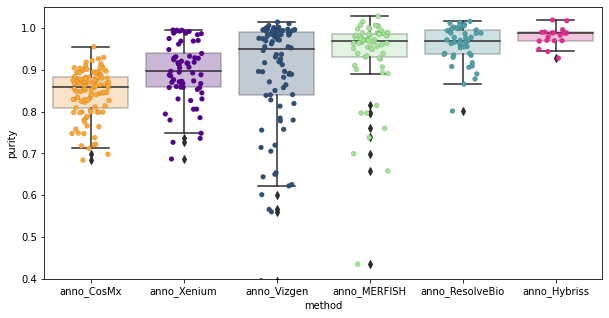

In [138]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
with plt.rc_context({'figure.figsize': (10, 5)}):
    sns.boxplot(x="method", y="purity",order=order, data=summary_of_results, palette=coli, boxprops=dict(alpha=.3))
    sns.stripplot(x="method", y="purity",edgecolor='black',order=order,
            linewidth=0.09, jitter=0.2,
             # colormap="Set3",# order=clarity_ranking,
               data=summary_of_results, palette=coli)
    plt.ylim([0.4,1.05])
    plt.savefig('../../figures/2.comparison_between_datasets/ratios_vs_sc/NegMarkerPurity_cortex_resegmented_segmentation_all.pdf')

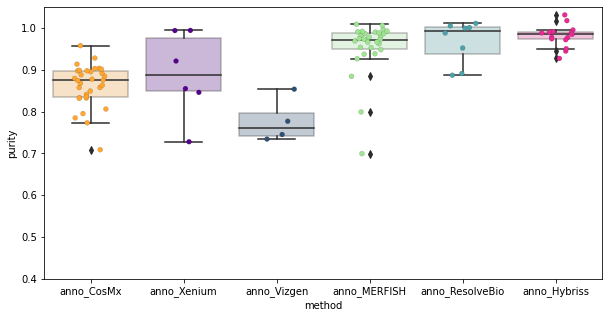

In [144]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
with plt.rc_context({'figure.figsize': (10, 5)}):
    sns.boxplot(x="method", y="purity",order=order, data=summary_of_results, palette=coli, boxprops=dict(alpha=.3))
    sns.stripplot(x="method", y="purity",edgecolor='black',order=order,
            linewidth=0.09, jitter=0.2,
             # colormap="Set3",# order=clarity_ranking,
               data=summary_of_results, palette=coli)
    plt.ylim([0.4,1.05])
    plt.savefig('../../figures/2.comparison_between_datasets/ratios_vs_sc/NegMarkerPurity_cortex_resegmented_segmentation.pdf')

In [154]:
summary_of_results['method']=[el.replace('anno_','') for el in summary_of_results['method']]

In [157]:
df_con_cortex['uni_id']=df_con_cortex['method']+'_'+df_con_cortex['gene']
summary_of_results['uni_id']=summary_of_results['method']+'_'+summary_of_results['gene']

In [159]:
merged_info=df_con_cortex.merge(summary_of_results,on='uni_id')

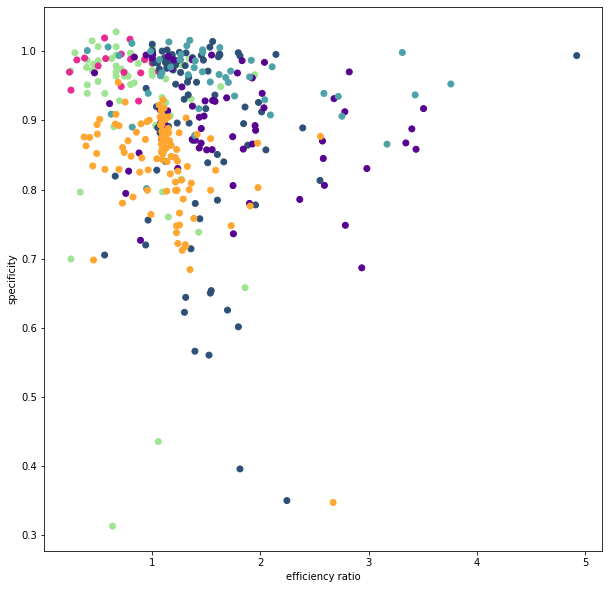

In [168]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(10,10))
plt.scatter(merged_info['ratio'],merged_info['purity'],c=merged_info['color'])
plt.xlabel('efficiency ratio')
plt.ylabel('specificity')
plt.savefig('../../figures/2.comparison_between_datasets/ratios_vs_sc/specificity_vs_efficiency_scatter_cortex.pdf')

<AxesSubplot:>

<Figure size 1440x288 with 0 Axes>

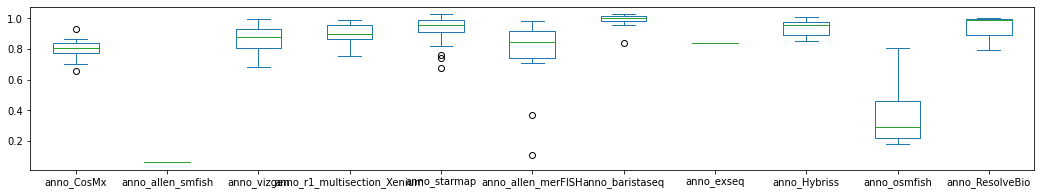

In [228]:
plt.figure(figsize=(20,4))
df_purity_filt.transpose().plot(kind='box',figsize=(18,3))

anno_allen_smfish.h5ad
anno_vizgen.h5ad
anno_Xenium.h5ad
anno_starmap.h5ad
anno_allen_merFISH.h5ad
anno_baristaseq.h5ad
anno_exseq.h5ad
anno_Hybriss.h5ad
anno_osmfish.h5ad
anno_ResolveBio.h5ad


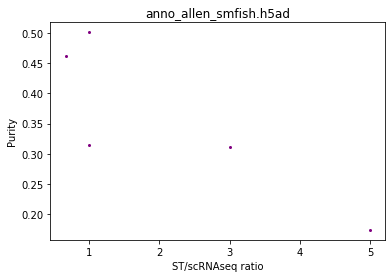

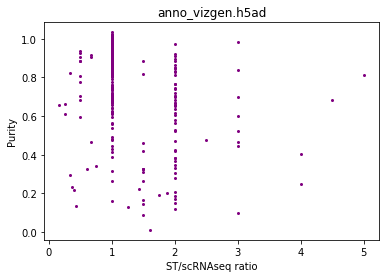

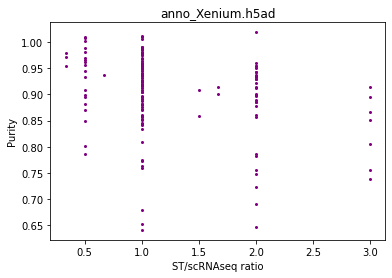

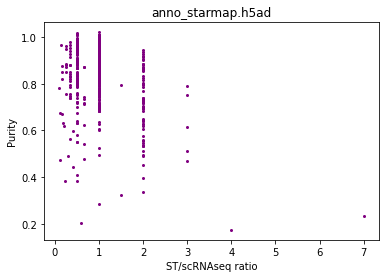

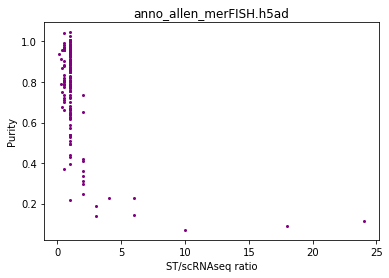

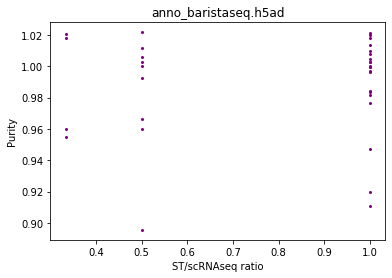

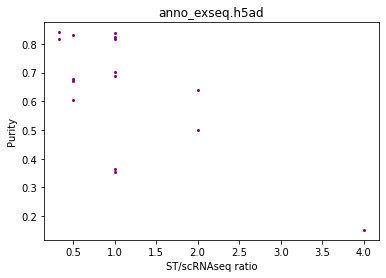

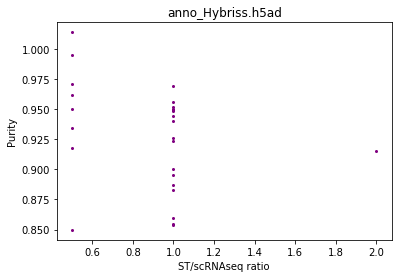

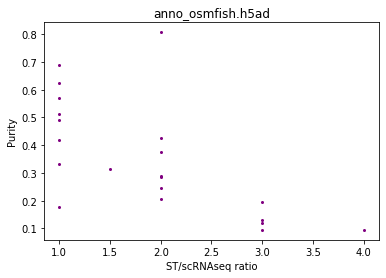

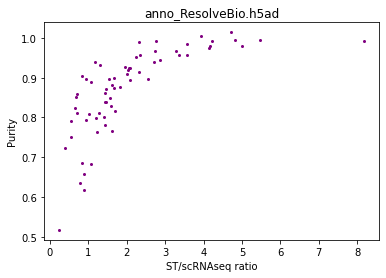

In [24]:
for c in df_ratio_filt.index:
    print(c)
    ratio_vs_purity=pd.DataFrame([df_ratio_filt.loc[c,:],df_purity_filt.loc[c,:]],index=['ratio','purity']).transpose()
    ratio_vs_purity=ratio_vs_purity[~ratio_vs_purity.min(axis=1).isna()]
    plt.figure()
    plt.scatter(ratio_vs_purity['ratio'],ratio_vs_purity['purity'],c='purple',s=4)
    plt.xlabel('ST/scRNAseq ratio')
    plt.ylabel('Purity')
    plt.title(c)

<AxesSubplot:>

<Figure size 720x288 with 0 Axes>

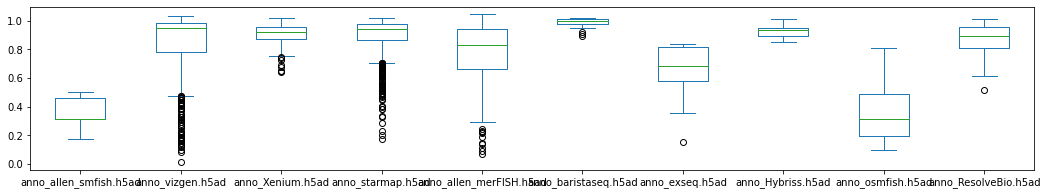

In [25]:
plt.figure(figsize=(10,4))
df_purity_filt.transpose().plot(kind='box',figsize=(18,3))

In [27]:
ratio_vs_purity['ratio>1']=ratio_vs_purity['ratio']>1

anno_allen_smfish.h5ad
anno_vizgen.h5ad
anno_Xenium.h5ad
anno_starmap.h5ad
anno_allen_merFISH.h5ad
anno_baristaseq.h5ad
anno_exseq.h5ad
anno_Hybriss.h5ad
anno_osmfish.h5ad
anno_ResolveBio.h5ad


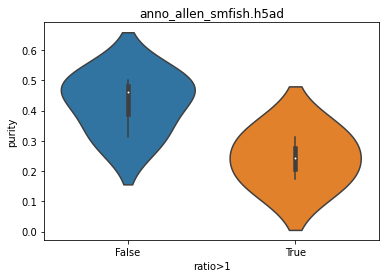

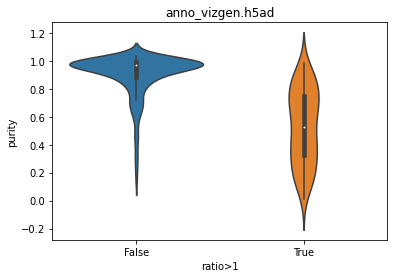

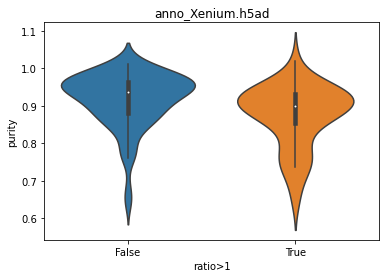

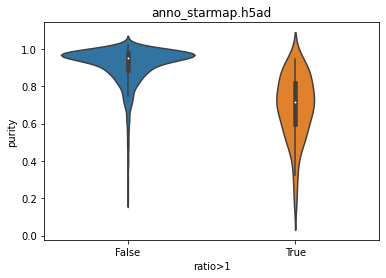

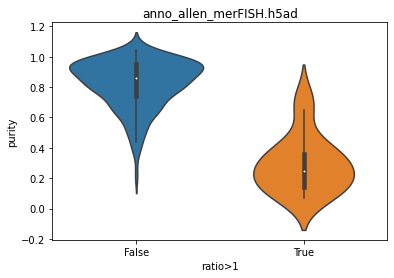

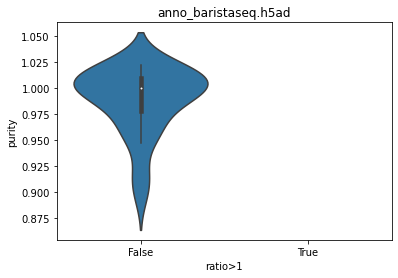

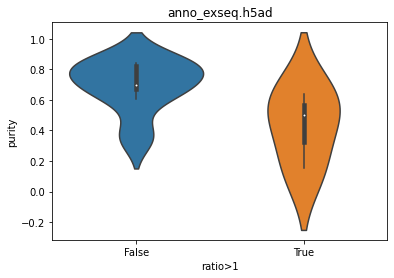

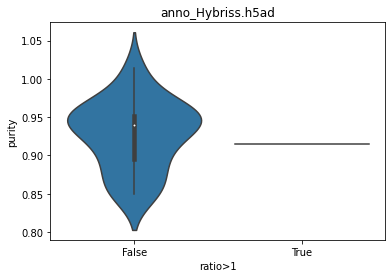

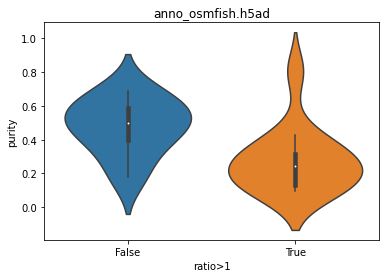

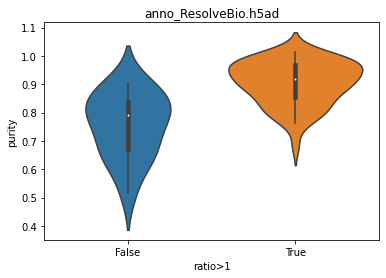

In [28]:
allrats=[]
for c in df_ratio_filt.index:
    print(c)
    ratio_vs_purity=pd.DataFrame([df_ratio_filt.loc[c,:],df_purity_filt.loc[c,:]],index=['ratio','purity']).transpose()
    ratio_vs_purity=ratio_vs_purity[~ratio_vs_purity.min(axis=1).isna()]
    ratio_vs_purity['ratio>1']=ratio_vs_purity['ratio']>1
    plt.figure()
    sns.violinplot(data=ratio_vs_purity,y='purity',x='ratio>1')
    plt.title(c)
    #ratio_vs_purity2=ratio_vs_purity[ratio_vs_purity['ratio>1']]
    ratio_vs_purity.loc[:,'sample']=c
    allrats.append(ratio_vs_purity)

In [29]:
ratios_divided=pd.concat(allrats)

<AxesSubplot:xlabel='sample', ylabel='purity'>

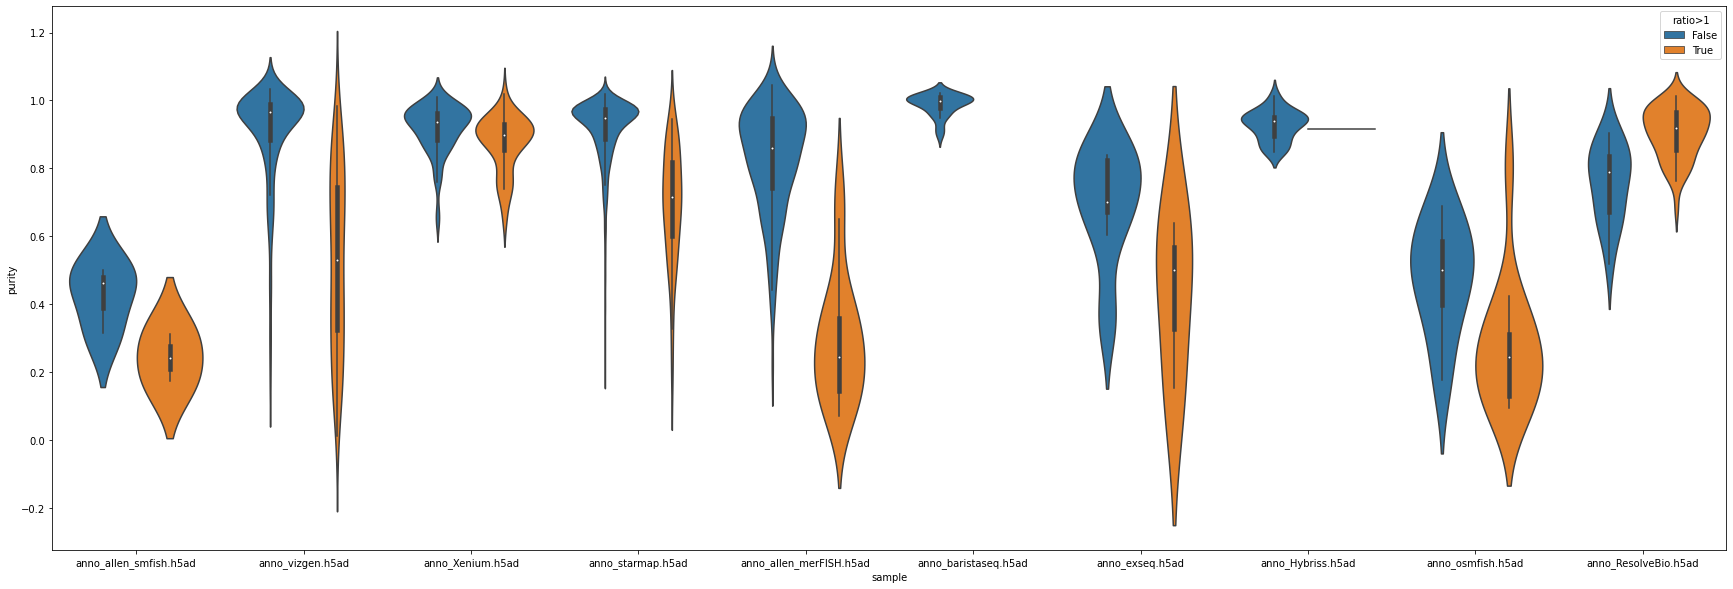

In [30]:
plt.figure(figsize=(30,10))
sns.violinplot(data=ratios_divided,y='purity',x='sample',hue='ratio>1')

In [301]:
df_purity_filt[df_ratio<1]=np.nan

In [ ]:
plt.figure(figsize=(10,4))
df_purity_filt.transpose().plot(kind='box',figsize=(18,3))

(68934, 247)
(149955, 247)


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:02<00:00, 100.74it/s]
/home/sergioms/miniconda3/envs/spatial2022/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


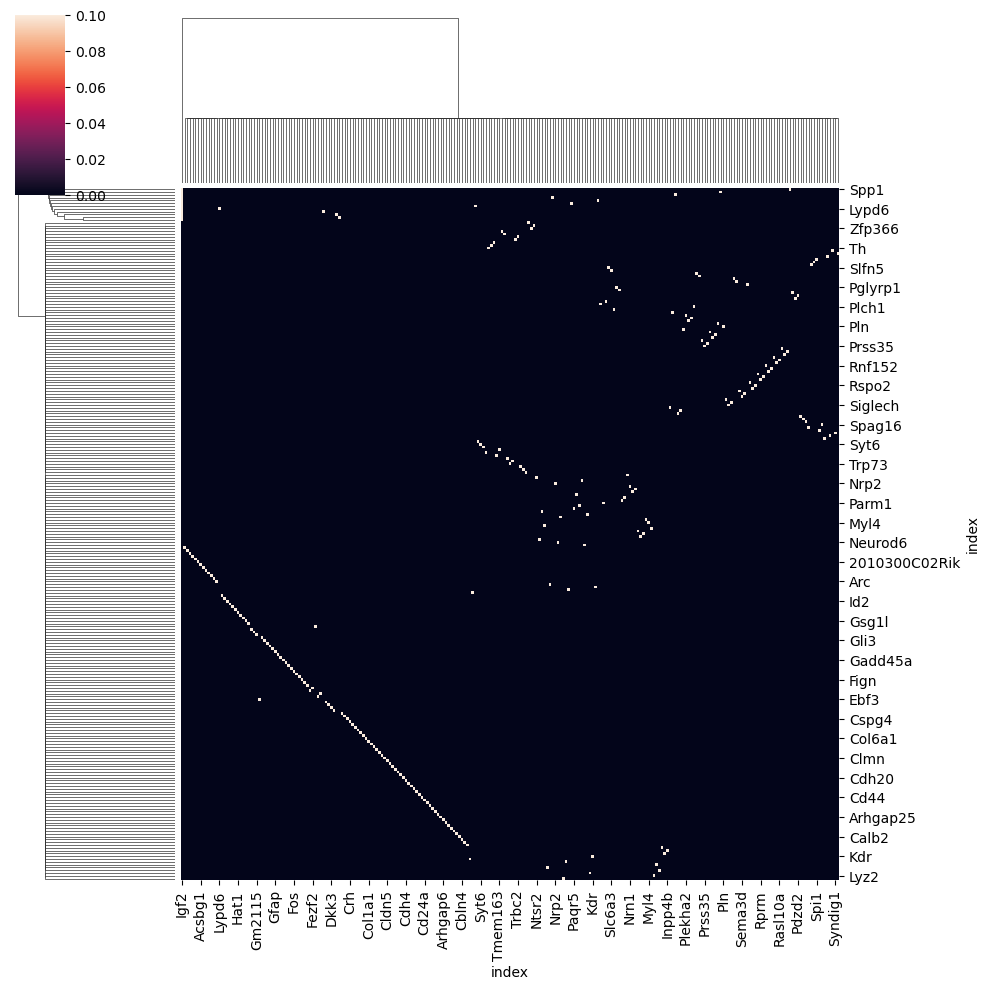

In [89]:
negative_marker_purity, purity_per_gene, purity_per_celltype,lowvals_sc,lowvals_sp=negative_marker_purity_coexpression(adata_sp, adata_sc,pipeline_output=False)

In [90]:
lowvals_sc

array([0.        , 0.00577355, 0.00892857, ..., 0.04709559, 0.04999087,
       0.        ])

In [91]:
lowvals_sp

array([0.3125    , 0.2996459 , 0.35287222, ..., 0.21558723, 0.14485981,
       0.10559117])

/home/sergioms/miniconda3/envs/spatial2022/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

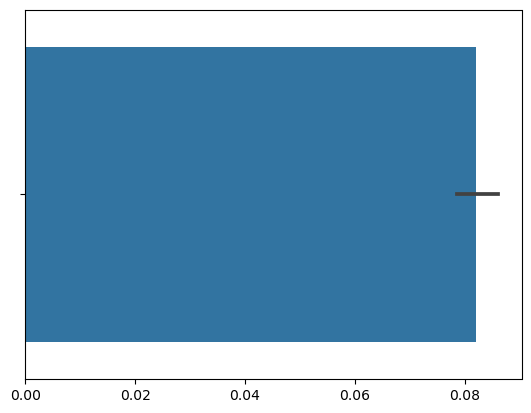

In [80]:
sns.barplot(list(purity_per_gene.astype(float)))

In [75]:
negative_marker_purity

0.9177942619230898

In [20]:
min_exp=0
exp_sc = pd.DataFrame(adata_sc.X,columns=adata_sc.var_names)
exp_sc=exp_sc.iloc[:,0:200]

In [36]:
coexpression_sc=coexpression_calculation(exp_sc)
coexpression_sp=coexpression_calculation(exp_sp)

C:\Users\sergio.salas\Miniconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


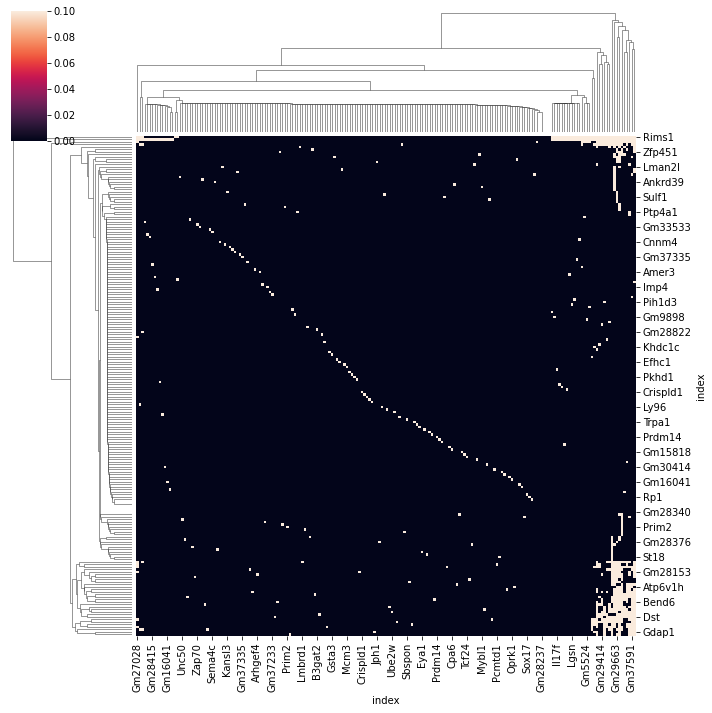

In [37]:
sns.clustermap(coexpression_sc.astype(int),vmax=0.1)